# Preprocess Data

In [1]:
import pystan
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
import seaborn

%matplotlib inline

In [2]:
### Import get columns and rows
data = pd.read_csv("co2.csv",sep=',', comment='"',header=None,names=["date", "co2"])
data["date"] = pd.to_datetime(data["date"])
data["years_passed"] = [(d-data["date"][0]).days/365.25 for d in data["date"]] # if variation is seasonal, we need year

/usr/local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


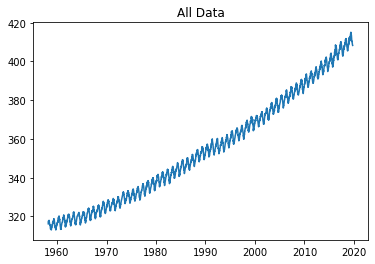

In [3]:
N = len(data)

n = 1500

plt.plot(data["date"],data["co2"]);
plt.title("All Data");

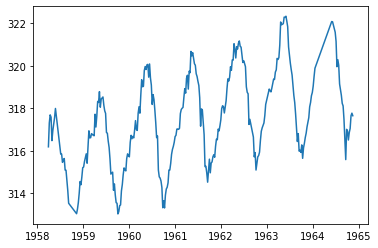

In [4]:
import matplotlib.dates as mdates

years = mdates.YearLocator()   # every year
years_fmt = mdates.DateFormatter('%Y')

fig, ax = plt.subplots()
ax.plot("date","co2",data=data[:300]);
ax.xaxis.set_major_locator(years);
ax.xaxis.set_major_formatter(years_fmt);

# First Impressions

Mostly linear, with a tiny quadratic trend.

Periodic by year.

In [5]:
[320+x+0.0001*x**2 for x in range(N)]

[320.0,
 321.0001,
 322.0004,
 323.0009,
 324.0016,
 325.0025,
 326.0036,
 327.0049,
 328.0064,
 329.0081,
 330.01,
 331.0121,
 332.0144,
 333.0169,
 334.0196,
 335.0225,
 336.0256,
 337.0289,
 338.0324,
 339.0361,
 340.04,
 341.0441,
 342.0484,
 343.0529,
 344.0576,
 345.0625,
 346.0676,
 347.0729,
 348.0784,
 349.0841,
 350.09,
 351.0961,
 352.1024,
 353.1089,
 354.1156,
 355.1225,
 356.1296,
 357.1369,
 358.1444,
 359.1521,
 360.16,
 361.1681,
 362.1764,
 363.1849,
 364.1936,
 365.2025,
 366.2116,
 367.2209,
 368.2304,
 369.2401,
 370.25,
 371.2601,
 372.2704,
 373.2809,
 374.2916,
 375.3025,
 376.3136,
 377.3249,
 378.3364,
 379.3481,
 380.36,
 381.3721,
 382.3844,
 383.3969,
 384.4096,
 385.4225,
 386.4356,
 387.4489,
 388.4624,
 389.4761,
 390.49,
 391.5041,
 392.5184,
 393.5329,
 394.5476,
 395.5625,
 396.5776,
 397.5929,
 398.6084,
 399.6241,
 400.64,
 401.6561,
 402.6724,
 403.6889,
 404.7056,
 405.7225,
 406.7396,
 407.7569,
 408.7744,
 409.7921,
 410.81,
 411.8281,
 412.8464

In [6]:
plt.plot(data["date"],data["co2"]);
plt.plot([x for x in range(N)],[320+x+x**2 for x in range(N)]);


Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x123d515f0> (for post_execute):


ValueError: view limit minimum -36866.5 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

ValueError: view limit minimum -36866.5 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

# Model Fit

In [17]:
stan_data = {
    'n': n,
    'x': data["co2"][:n],
    'time': data["years_passed"][:n],
    'n_future': N-n
}  # Stan gets to see the first n data values only


In [ ]:
# The Stan model. Running this cell compiles the Stan model, which takes
# some time.

stan_code = """
data {
    int<lower=0> n;        // The number of data
    real x[n];             // The co2 data
    real<lower=0> time[n];  // Time (in years passed)
    int<lower=0> n_future;
}

parameters {
    // _____POLY_____
    real<lower=0> C0;                   // constant
    real<lower=0> C1;                   // x multiplier
    real<lower=0> C2;                   // x^2 multiplier
    
    // _____PERIODIC_____
    real<lower=0> A;           // amplitude
    real phi_x;                // dummy var for phi
    real phi_y;                // "               "
    
    // _____NOISE_____
    real<lower=0> sigma;

}

transformed parameters {
    // atan converts to range [-pi,pi]
    real phi = atan2(phi_x, phi_y); // offset for period
}

model {
    // _____PRIORS_____
    C0 ~ normal(300, 50);
    C1 ~ normal(0, 1);
    C2 ~ normal(0,1);
    A ~ normal(3,2);
    sigma ~ gamma(1, 0.3);
    
    // _____MODEL_____
    for(t in 1:n) {
        x[t] ~ normal(
            C0 + C1*t + C2*t^2 + A*cos(2*pi()*time[t] + phi),
            sigma^2);
    }
}

// Generate the predicted function values for the next n_future steps.
generated quantities {
    real x_future[n_future];
    for(t in 1:n_future) {
        x_future[t] = normal_rng(
            C0 + C1*t + C2*t^2 + A*cos(2*pi()*time[t] + phi),
            sigma^2);
    }
}

"""

stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f2cf8a347d5c14a09968fb67d0ef42e9 NOW.


In [ ]:
# Run Hamiltonian Monte Carlo using Stan with 4 Markov chains, a 1000 step
# warm-up phase and 1000 step sampling phase for each chain. The warm-up samples
# are discarded, so we are left with 4 x 1000 = 4000 samples.

# This cell will take a minute or two to run.

parameters = ['C0','C1','C2','A','phi','sigma']

results = stan_model.sampling(data=stan_data)
print(results.stansummary(pars=parameters))
samples = results.extract()

In [ ]:
# Plot sample autocorrelation for each parameter.

def plot_acf(x):
    '''
    Plot the autocorrelation function for a series x. This corresponds to the
    acf() function in R. The series x is detrended by subtracting the mean of
    the series before computing the autocorrelation.
    '''
    from scipy import signal
    plt.acorr(
        x, maxlags=20, detrend=lambda x: signal.detrend(x, type='constant'))


for param in parameters:
    plt.figure(figsize=(12, 4))
    plot_acf(samples[param])
    plt.title(f'Autocorrelation of {param} samples')

plt.show()

In [ ]:
# Make pair plot of the posteriors over all parameters of the model.
df = pd.DataFrame(
    data=np.transpose([samples[param] for param in parameters]),
    columns=parameters)
seaborn.pairplot(df, size=2.5, plot_kws={'marker': '.', 'alpha': 0.25})
plt.show()

In [ ]:
pL = np.percentile(samples["x_future"],axis=0,q=2.5)
pU = np.percentile(samples["x_future"],axis=0,q=97.5)


In [12]:
pi_c0 = np.percentile(samples["C0"], axis=0, q=[2.5, 97.5])
pi_c1 = np.percentile(samples["C1"], axis=0, q=[2.5, 97.5])
pi_c2 = np.percentile(samples["C2"], axis=0, q=[2.5, 97.5])
pi_a = np.percentile(samples["A"], axis=0, q=[2.5, 97.5])
pi_p = np.percentile(samples["phi"], axis=0, q=[2.5, 97.5])
pi_s = np.percentile(samples["sigma"], axis=0, q=[2.5, 97.5])

In [ ]:
'''
# hella slow
import math

pL = []
pU = []

for t in data["years_passed"]:
    pred = []
    for i in range(4000):
        pred.append(stats.norm.rvs(samples["C0"][i] + samples["C1"][i]*t + samples["C2"][i]*t**2 + samples["A"][i]*math.cos(2*math.pi*t + samples["phi"][i]), samples["sigma"][i]**2))
    pL.append(np.percentile(pred, axis=0,q=2.5))
    pU.append(np.percentile(pred, axis=0,q=97.5))
'''   

In [ ]:
plt.plot([i for i in range(N)],data["co2"]);
plt.plot([i for i in range(N)],pL,alpha=0.5);
plt.plot([i for i in range(N)],pU,alpha=0.5);


In [ ]:
plt.plot([i for i in range(100)],data["co2"][:100]);
plt.plot([i for i in range(100)],pL[:100],alpha=0.5);
plt.plot([i for i in range(100)],pU[:100],alpha=0.5);


In [ ]:
# for ref

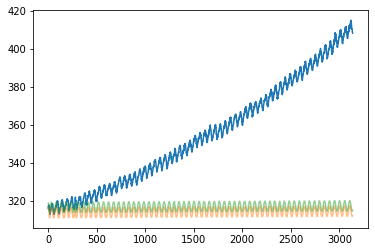

In [15]:
plt.plot([i for i in range(N)],data["co2"]);
plt.plot([i for i in range(N)],pL,alpha=0.5);
plt.plot([i for i in range(N)],pU,alpha=0.5);


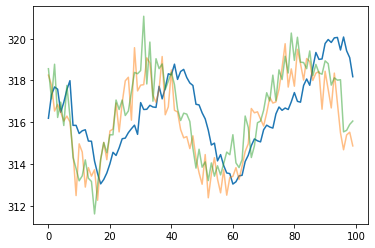

In [232]:
plt.plot([i for i in range(100)],data["co2"][:100]);
plt.plot([i for i in range(100)],pL[:100],alpha=0.5);
plt.plot([i for i in range(100)],pU[:100],alpha=0.5);
